In [2]:
import torch
import torchvision
import matplotlib
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from src.training_controller import Trainer
from src.helper_funcs import conv_block, ResidualBlock, calculate_accuracy
from datetime import datetime
from torchvision.models import resnet50, ResNet50_Weights

print(torch.cuda.is_available())

True


## Model 

Adjusting the Resnet50 model to the projects needs

In [7]:
model = torchvision.models.resnet50(weights= ResNet50_Weights)
model.fc = nn.Linear(in_features=2048, out_features=6, bias=True)

## Defining transforms and training parameters

Here the training parameters and methods of data augmentation are defined to help the model generalize. <br>

During training I also chose to use a scheduler and momentum to help the algortihm converge.

In [8]:
my_transforms = transforms.Compose(
    [
        transforms.CenterCrop(size=(64, 64)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        # transforms.ColorJitter(brightness=(0.5, 1.5), contrast=(1), saturation=(0.5, 1.5), hue=(-0.1, 0.1)),
        transforms.ToTensor()
    ])

my_eval_transforms = transforms.Compose(
    [
        transforms.CenterCrop(size=(100, 100)),
        transforms.ToTensor(),
    ])

batch_size = 32
max_lr = 0.03

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),
                      lr=max_lr,
                      weight_decay=1e-4,
                      momentum=0.9
                     )

scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, step_size_up = 20, base_lr=0.0003, max_lr=max_lr)


## Training

Trainer class which offers a training method and validation methods. Currently, the class expects the data to be in an [imagefolder](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html) type fashion.

In [9]:
my_trainer = Trainer(model, 'Data/seg_train/', 'Data/seg_test',
                  transform=my_transforms, eval_transform=my_eval_transforms,
                  gradient_clipping=True, batch_size=32, loss_function=criterion,
                  optimizer=optimizer, scheduler=scheduler, epochs=30)

In [10]:
my_trainer.train()

Training on  NVIDIA GeForce GTX 1060 6GB
Started training at: 20:14:49
Epoch [0]: loss: 0.8141304767756364, time finished: 2022-11-18 20:16:52.322690, learning rate: 0.0017849999999999945, train acc 82 %
Epoch [1]: loss: 0.5623400064359222, time finished: 2022-11-18 20:18:08.778838, learning rate: 0.003270000000000002, train acc 85 %
Epoch [2]: loss: 0.5278592005813312, time finished: 2022-11-18 20:19:25.194449, learning rate: 0.004754999999999997, train acc 87 %
Epoch [3]: loss: 0.497132498609721, time finished: 2022-11-18 20:20:41.618068, learning rate: 0.006240000000000004, train acc 85 %
Epoch [4]: loss: 0.6571918523664626, time finished: 2022-11-18 20:21:57.992645, learning rate: 0.007724999999999999, train acc 40 %
Epoch [5]: loss: 0.885906950012698, time finished: 2022-11-18 20:23:14.445790, learning rate: 0.009209999999999994, train acc 80 %
Epoch [6]: loss: 0.5599488618365724, time finished: 2022-11-18 20:24:30.709771, learning rate: 0.010695000000000001, train acc 82 %
Epoch 

KeyboardInterrupt: 

## Evaluate the model

A function which takes a dataloader and a model as an input an returns the accuracy

In [11]:
acc = calculate_accuracy(my_trainer._testloader, my_trainer.getModel())
acc

86

visualize_results() gives a quick overview of how the loss and accuracy behaved during training in a simple line plot

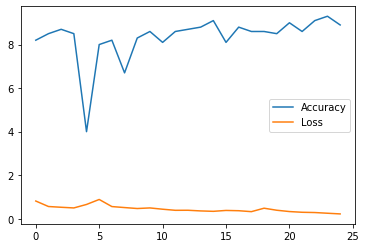

In [12]:
my_trainer.visualize_results()

visualize_incorrectly_classified_images() takes an integer n as an input and displays an array of n random images that have been incorrectly classified by the model. This might help identifying what classes the model fails to identify properly and may guide one to different augmentation techniques.

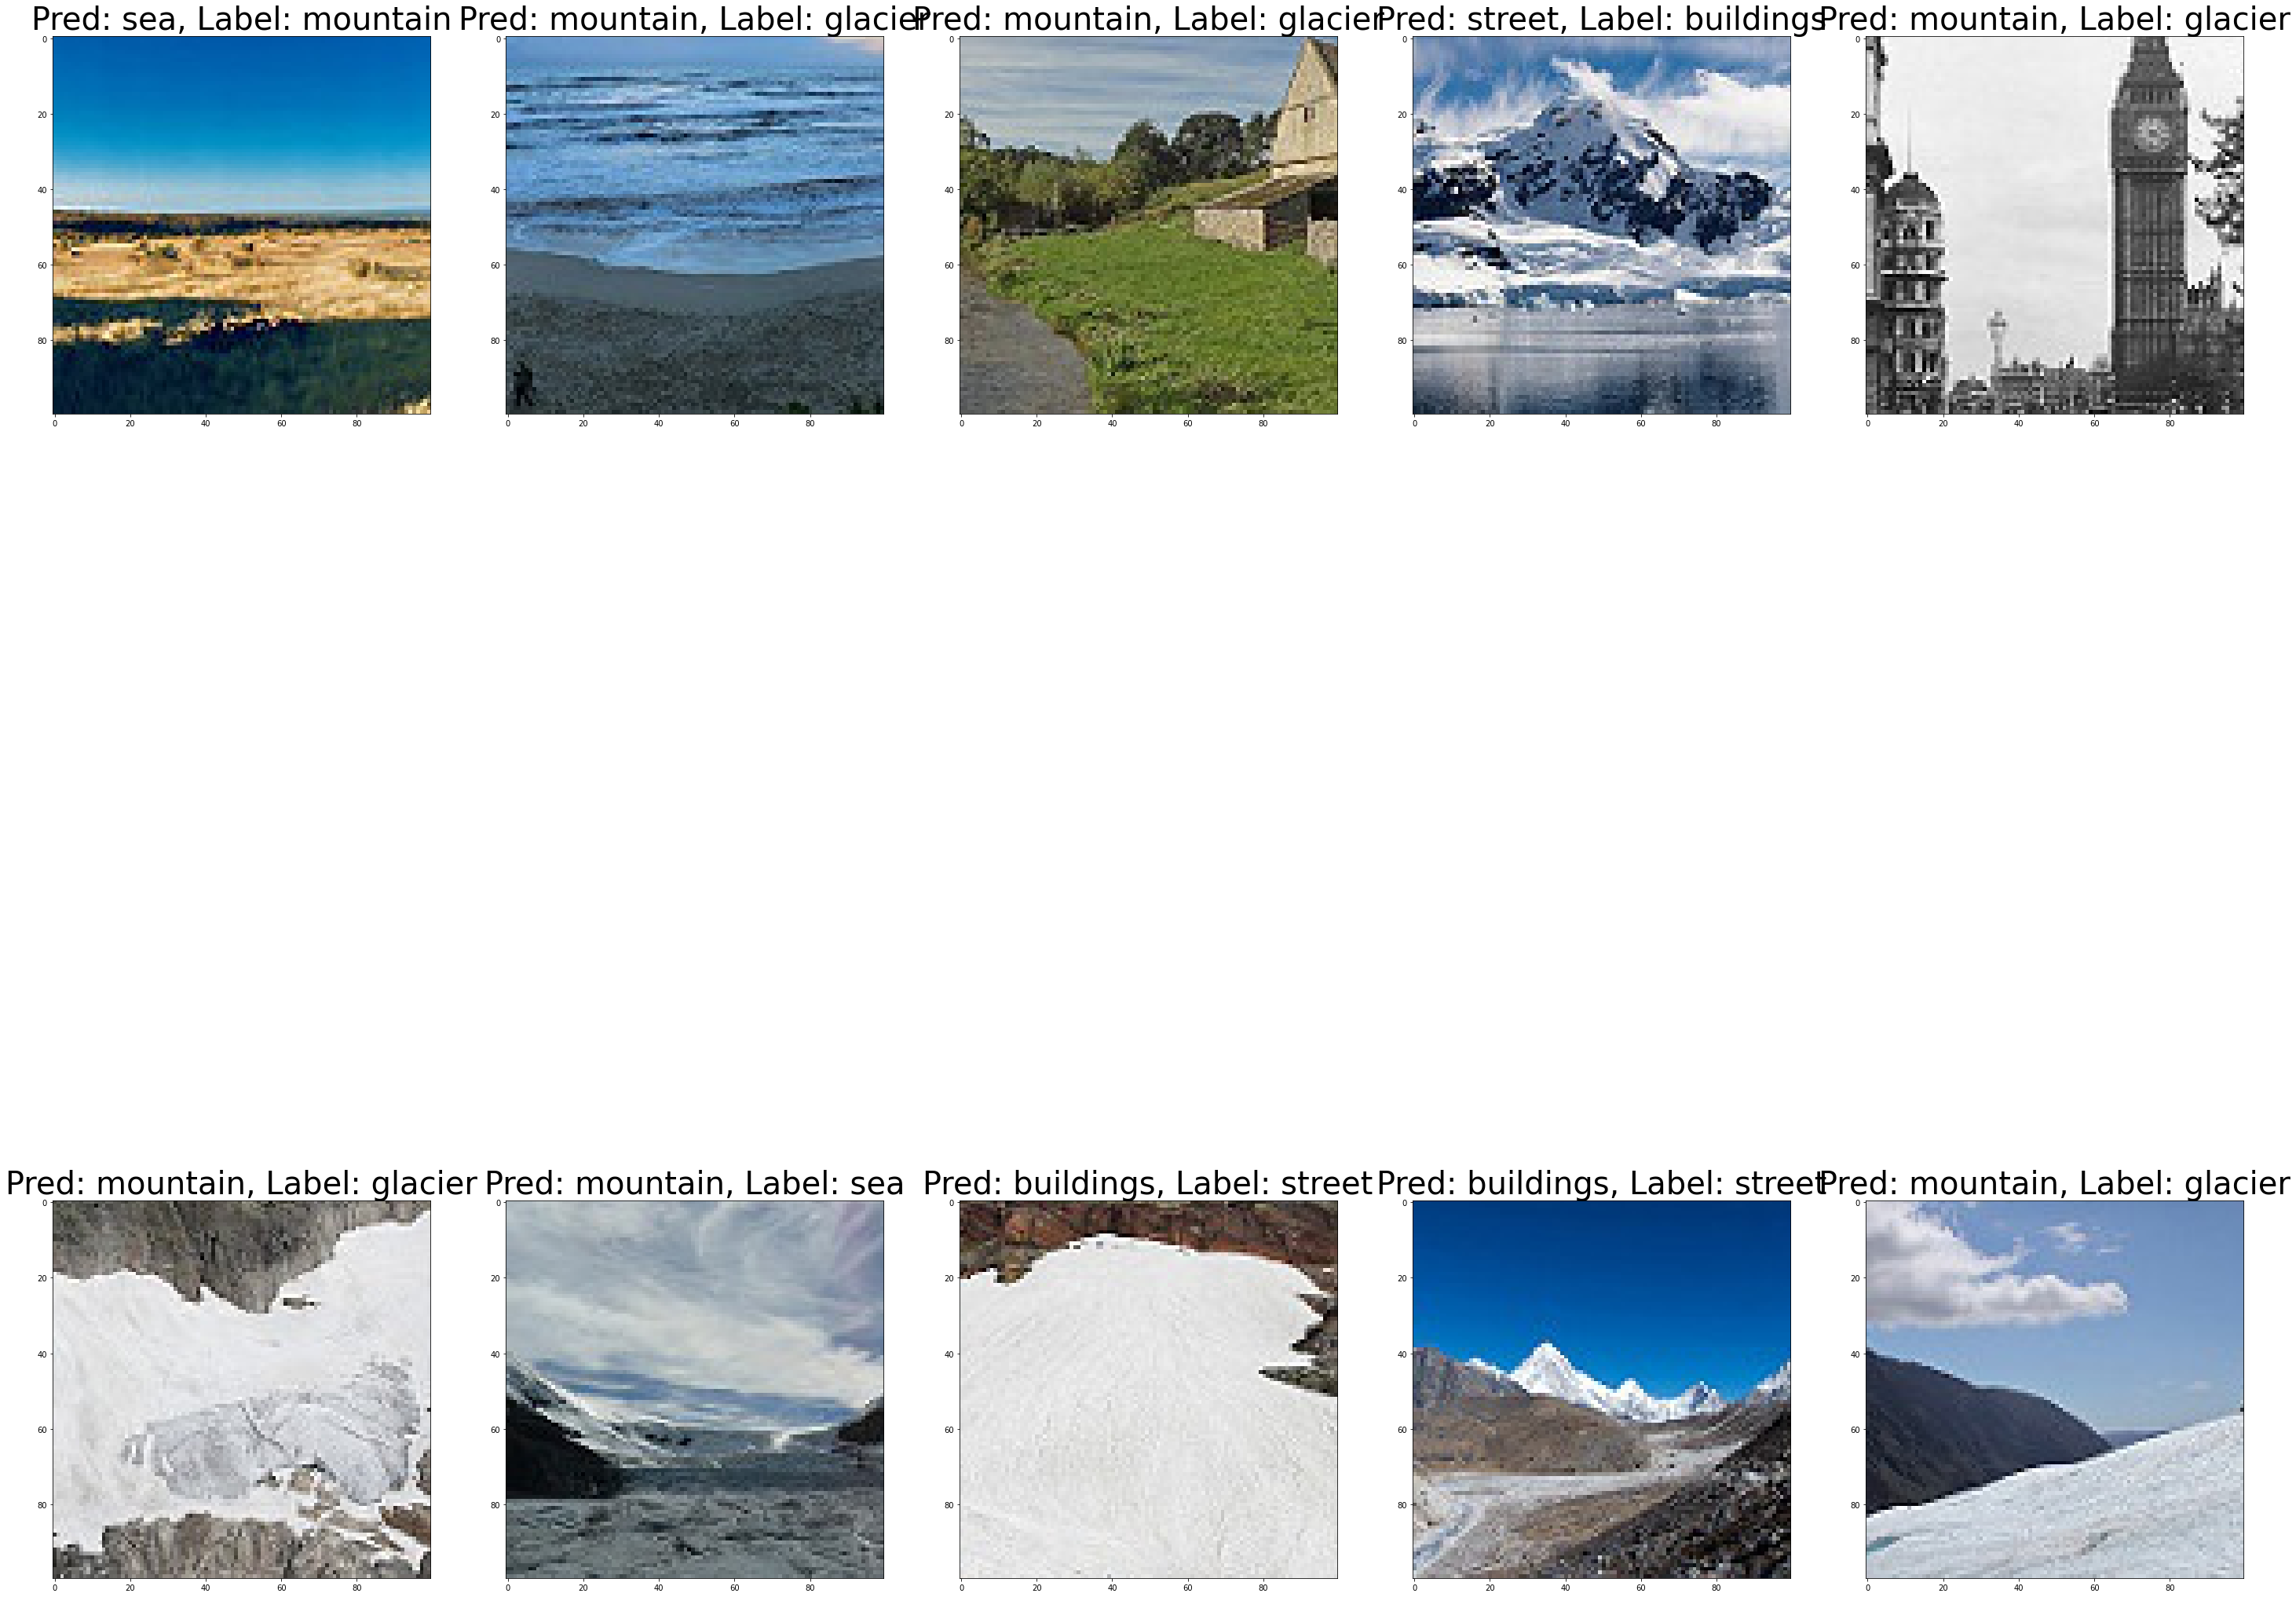

In [13]:
my_trainer.visualize_incorrectly_classified_images(10)

## Save the model

Save the model as a script such that the python class doesn't need to be defined anymore when loading the model back in.

In [14]:
m = torch.jit.script(my_trainer.getModel())
torch.jit.save(m, "Models/finetuned_model.pt")

## Demonstration on a single image

In [15]:
model = torch.jit.load("Models/script.pt")

In [16]:
from PIL import Image

In [17]:
img = Image.open("image.JPG")
transform = transforms.Compose(
    [
        transforms.Resize((100, 100)),
        transforms.ToTensor(),
    ])

img = transform(img)

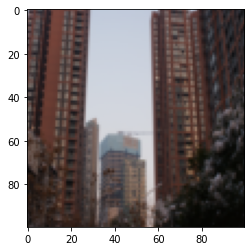

In [18]:
import matplotlib.pyplot as plt
plt.imshow( img.permute(1, 2, 0) )

In [19]:
pred_translator = {
    0: "buildings",
    1: "forest",
    2: "glacier",
    3: "mountain",
    4: "sea",
    5: "street",
}

img = torch.unsqueeze(img, 0)
img = img.to('cuda')

outputs = my_trainer.getModel()(img)
_, preds = torch.max(outputs, dim=1)
print(outputs, pred_translator[preds.item()])

tensor([[ 4.2835,  1.1809, -3.5394, -2.6996, -2.7431,  3.4838]],
       device='cuda:0', grad_fn=<AddmmBackward0>) buildings
